<a href="https://colab.research.google.com/github/qpwisu/Financial_data_analysis/blob/main/%EC%9B%90%EC%9E%90%EC%9E%AC%EC%99%80_%EC%A3%BC%EC%8B%9D%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bs4
!pip install pykrx

     |████████████████████████████████| 92 kB 238 kB/s 
     |████████████████████████████████| 51 kB 107 kB/s 
     |████████████████████████████████| 251 kB 26.1 MB/s 


In [54]:
#https://buyandpray.tistory.com/39
#https://kr.investing.com/에서 ajax를 통해 서버에 요청해 철광석 가격을 받아왔다
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
def x(y):
  z=re.sub(",","",y)
  return z
def getRawMaterials(st_date, end_date, curr_id, smlID , name):
  headers = {
    'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36',
    'X-Requested-With' : 'XMLHttpRequest'
  }
  formData = {
      "curr_id" : curr_id,
      "smlID" :smlID,
      "header" : "",
      "st_date" : st_date,
      "end_date" : end_date,
      "interval_sec" : "Daily",
      "sort_col" : "date",
      "sort_ord" : "DESC",
      "action" : "historical_data"
  }

  POSTURL = r"https://kr.investing.com/instruments/HistoricalDataAjax"


  formData["header"] = name + " 내역"

  response = requests.post(POSTURL, headers=headers, data=formData)
  if response.status_code == 200:
      html = response.text
      soup = BeautifulSoup(html,'html.parser') 
      items= soup.select("tr")
      items = items[1:-1]
      li= []

      for item in items:
        i = item.text.split("\n")[1:7]
        i[0]=re.sub(r"(\d{4})년 (\d{2})월 (\d{2})일",r"\g<1>\g<2>\g<3>",i[0])
        i.append(i[5].split(" ")[1])
        i[5]= i[5].split(" ")[0]
        li.append(i)
      name_list = ["날짜","종가","오픈","고가",'저기',"거래량","변동%"]
      df = pd.DataFrame(li,columns=name_list)
      df.set_index("날짜",inplace=True)
      df=df[::-1]
      
      index1 =df["종가"].apply(x).to_frame(name=name)

      index1=index1.astype('float')
      index1.reset_index(inplace=True)
      index1=index1.astype({'날짜':'string'})
      index1.set_index("날짜",inplace=True)
      return index1
   

In [3]:
from pykrx import stock
from pykrx import bond
from tqdm import tqdm
def stock_price(index1,stock_li):
  for i in tqdm(stock_li):
    df2 = stock.get_market_ohlcv("20210601", "20220213", i)
    index2 = df2["종가"].to_frame(name=i)
    index2=index2.astype('float')
    index2.reset_index(inplace=True)
    index2=index2.astype({'날짜':'string'})
    index2.set_index("날짜",inplace=True)
    index1=pd.merge(index1, index2,left_index=True, right_index=True ,how='outer')
  return index1
    

철광석의 경우 관련 종목과의 상관관계가 양의 상관계수로 꽤 높게 측정된다. 철광석가격이 오를 수록 주가 역시 오른다 

060380    0.616154

084010    0.588009

017480    0.587893

008260    0.571037

002220    0.515273

100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

철광석      NaN
001230   NaN
060380   NaN
001080   NaN
017480   NaN
084010   NaN
058430   NaN
002220   NaN
008260   NaN
016380   NaN
Name: 철광석, dtype: float64


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52384 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_ag

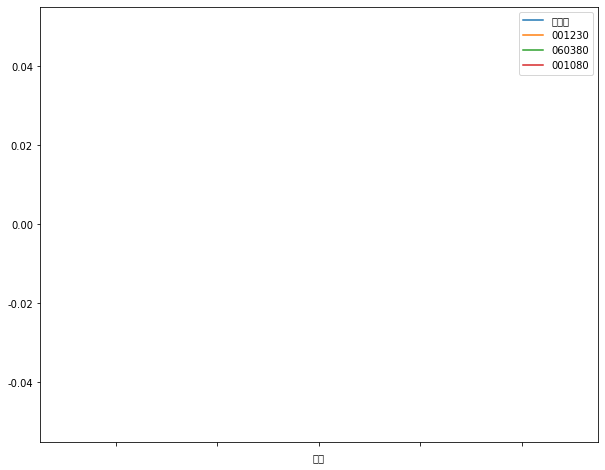

In [4]:
index1=getRawMaterials("2021/09/01","2022/02/15","961729","301009","철광석")
stock_li = ["001230","060380","001080","017480","084010","058430","002220","008260","016380"]
index1= stock_price(index1,stock_li)
index1 =index1.dropna(axis=0)
#상관관계 1998140207971
corr = index1.corr(method = 'pearson')
high_correlation=corr.iloc[0].sort_values(ascending = False)[0:4].index.tolist()
high_correlation=index1[high_correlation]
print(corr.iloc[0].sort_values(ascending = False))

#정규화
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())
df_minmax_norm = minmax_norm(high_correlation)
df_minmax_norm.plot.line(figsize=(10,8))

구리와 관련주들의 상관계수가 낮은편이다 큰 영향을 끼치지 않는다는 의미 

구리        1.000000
025820    0.112664
103140    0.077099
012800   -0.011777
021050   -0.182484
229640   -0.098569
Name: 구리, dtype: float64


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text

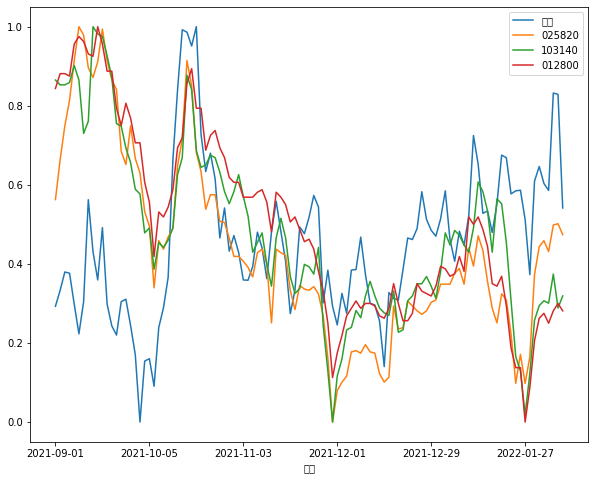

In [ ]:
index1=getRawMaterials("2021/09/01","2022/02/15","8831","300012","구리")

stock_li = ["025820","103140","012800","021050","229640"]
index1= stock_price(index1,stock_li)
index1 =index1.dropna(axis=0)
#상관관계 1998140207971
corr = index1.corr(method = 'pearson')
high_correlation=corr.iloc[0].sort_values(ascending = False)[0:4].index.tolist()
high_correlation=index1[high_correlation]
print(corr.iloc[0])

#정규화
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())
df_minmax_norm = minmax_norm(high_correlation)
df_minmax_norm.plot.line(figsize=(10,8))


알루미늄도 상관계수가 낮게 나온다 

알루미늄      1.000000
006110    0.095683
001530   -0.068785
018470    0.299780
069460   -0.263459
128660   -0.107890
186230    0.226369
054410    0.040189
009620   -0.325253
008350   -0.063591
009520   -0.207327
177830    0.303111
Name: 알루미늄, dtype: float64


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50508 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47336 missing from current font.
  font.set_text

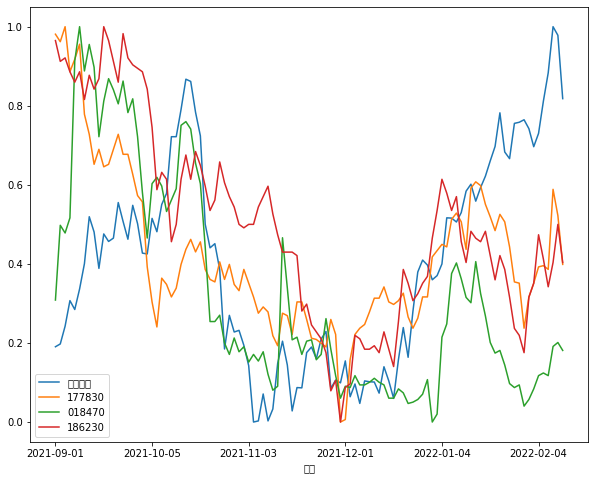

In [ ]:
index1=getRawMaterials("2021/09/01","2022/02/15","49768","300586","알루미늄")
stock_li = ["006110","001530","018470","069460","128660","186230","054410","009620","008350","009520","177830"]
index1= stock_price(index1,stock_li)
index1 =index1.dropna(axis=0)
#상관관계 1998140207971
corr = index1.corr(method = 'pearson')
high_correlation=corr.iloc[0].sort_values(ascending = False)[0:4].index.tolist()
high_correlation=index1[high_correlation]
print(corr.iloc[0])

#정규화
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())
df_minmax_norm = minmax_norm(high_correlation)
df_minmax_norm.plot.line(figsize=(10,8))

In [42]:
#모든종목 종가 dataframe으로 가져오기 

start_day = "20180101"
end_day = "20220216"
def str_day(d):
  return d.strftime('%Y%m%d')
tmp = stock.get_market_ohlcv(start_day, end_day, "005930")
days= list(map(str_day,tmp.index.to_list()))


tmp = stock.get_market_ohlcv(days[0], market="ALL")
df_stock=tmp["종가"].to_frame(name=days[0]).T
for day in tqdm(days[1:]):
  ddf = stock.get_market_ohlcv(day, market="ALL")
  a=ddf["종가"].to_frame(name=str(day)).T
  df_stock=pd.concat([df_stock,a])

df_stock

100%|██████████| 1015/1015 [23:21<00:00,  1.38s/it]


티커,060310,095570,068400,006840,054620,265520,211270,027410,282330,138930,001460,001465,032040,001040,079160,130960,000120,011150,011155,035760,001045,097950,097955,051500,037560,058820,023460,065770,083660,000590,012030,016610,045890,005830,000990,000995,139130,068790,004840,241520,...,382480,248020,261780,114840,377450,382800,348370,377300,376180,389030,376300,357880,372800,311320,290090,400760,361570,377480,402340,402420,397500,03481K,396690,404990,254160,403360,298870,397880,400840,396770,400560,404950,353590,169670,102370,373220,276040,377330,136410,137080
20180102,1880,6970,10200,73600,7620,35350,8390,15500,210500,9430,304000,152000,4375.0,176500,75600,96100.0,144000,2890,26450,224800,75800,371500,153500,38500,7110,7580,1315,1900,3800,80100,697,4030,1955.0,70300,11850,34700,10500,6730,7850,5610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180103,1995,6920,10100,71700,7790,35600,8590,15450,202500,9310,301000,151000,4375.0,178000,70900,93900.0,145000,2865,28500,222100,76000,371000,155000,36850,7060,7210,1315,2070,3820,81400,715,4075,2025.0,69000,11900,33000,10650,6830,7740,5580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180104,2000,7070,10100,72400,7570,34350,8900,15050,200500,9280,300500,150000,4375.0,176000,71600,91000.0,145000,2840,30500,212500,75500,376500,158500,36900,6940,6910,1315,2070,3790,81000,731,4100,2100.0,67200,12300,33350,10600,6590,7550,6500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180105,2180,7250,10200,72400,7480,34050,8820,14600,200000,9280,300000,150500,4375.0,174500,72100,91000.0,141500,2845,29900,217000,74700,370000,158000,35300,6950,7140,1315,2040,3880,80100,718,4195,2100.0,67400,11950,33300,10900,6500,7650,6360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180108,2420,7130,10050,72500,7580,33600,8870,14600,199000,9480,300000,151000,4375.0,173500,71500,91500.0,139000,2795,28600,218200,73900,372000,158500,35200,6870,7060,1315,1975,3815,79600,705,4265,2155.0,67600,12200,32850,10900,6320,7450,6520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220210,2950,5140,10300,19900,11250,22300,13150,5000,169500,8540,462500,177500,NaN,85000,24350,NaN,127500,3805,37800,132300,48600,383000,165500,35350,4800,3340,2275,3000,1670,64800,899,6550,NaN,64800,70700,99900,9780,6660,5160,6050,...,20500.0,24000.0,8500.0,21300.0,12050.0,19600.0,104300.0,128000.0,16500.0,10750.0,50100.0,15500.0,17100.0,24900.0,22450.0,5140.0,21000.0,22900.0,57100.0,15100.0,2105.0,20150.0,5700.0,4915.0,7160.0,10050.0,4360.0,2140.0,2110.0,2115.0,2605.0,2105.0,14550.0,4795.0,32400.0,474500.0,26600.0,19600.0,13100.0,13350.0
20220211,2945,5230,10150,20000,11250,22100,12800,5000,167500,8500,452500,178000,NaN,83700,24400,NaN,124500,3840,37750,125500,48300,376000,164000,34400,5290,3175,2220,2800,1625,63700,874,6510,NaN,64900,69300,97600,9980,6570,5150,6030,...,19400.0,25000.0,8810.0,20600.0,12200.0,19650.0,101300.0,126500.0,15900.0,10800.0,45000.0,14550.0,15800.0,22600.0,21200.0,5140.0,20050.0,22700.0,56800.0,15050.0,2105.0,20850.0,5630.0,4955.0,7070.0,9970.0,4295.0,2140.0,2110.0,2125.0,2585.0,2110.0,14900.0,5000.0,30000.0,482000.0,2700

In [72]:

df_stock.to_csv("filename.csv",mode='w')
df_stock1 = pd.read_csv("filename.csv", dtype=str,index_col=0)
df_stock1


,060310,095570,068400,006840,054620,265520,211270,027410,282330,138930,001460,001465,032040,001040,079160,130960,000120,011150,011155,035760,001045,097950,097955,051500,037560,058820,023460,065770,083660,000590,012030,016610,045890,005830,000990,000995,139130,068790,004840,241520,...,382480,248020,261780,114840,377450,382800,348370,377300,376180,389030,376300,357880,372800,311320,290090,400760,361570,377480,402340,402420,397500,03481K,396690,404990,254160,403360,298870,397880,400840,396770,400560,404950,353590,169670,102370,373220,276040,377330,136410,137080
20180102,1880,6970,10200,73600,7620,35350,8390,15500,210500,9430,304000,152000,4375.0,176500,75600,96100.0,144000,2890,26450,224800,75800,371500,153500,38500,7110,7580,1315,1900,3800,80100,697,4030,1955.0,70300,11850,34700,10500,6730,7850,5610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180103,1995,6920,10100,71700,7790,35600,8590,15450,202500,9310,301000,151000,4375.0,178000,70900,93900.0,145000,2865,28500,222100,76000,371000,155000,36850,7060,7210,1315,2070,3820,81400,715,4075,2025.0,69000,11900,33000,10650,6830,7740,5580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180104,2000,7070,10100,72400,7570,34350,8900,15050,200500,9280,300500,150000,4375.0,176000,71600,91000.0,145000,2840,30500,212500,75500,376500,158500,36900,6940,6910,1315,2070,3790,81000,731,4100,2100.0,67200,12300,33350,10600,6590,7550,6500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180105,2180,7250,10200,72400,7480,34050,8820,14600,200000,9280,300000,150500,4375.0,174500,72100,91000.0,141500,2845,29900,217000,74700,370000,158000,35300,6950,7140,1315,2040,3880,80100,718,4195,2100.0,67400,11950,33300,10900,6500,7650,6360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180108,2420,7130,10050,72500,7580,33600,8870,14600,199000,9480,300000,151000,4375.0,173500,71500,91500.0,139000,2795,28600,218200,73900,372000,158500,35200,6870,7060,1315,1975,3815,79600,705,4265,2155.0,67600,12200,32850,10900,6320,7450,6520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220210,2950,5140,10300,19900,11250,22300,13150,5000,169500,8540,462500,177500,NaN,85000,24350,NaN,127500,3805,37800,132300,48600,383000,165500,35350,4800,3340,2275,3000,1670,64800,899,6550,NaN,64800,70700,99900,9780,6660,5160,6050,...,20500.0,24000.0,8500.0,21300.0,12050.0,19600.0,104300.0,128000.0,16500.0,10750.0,50100.0,15500.0,17100.0,24900.0,22450.0,5140.0,21000.0,22900.0,57100.0,15100.0,2105.0,20150.0,5700.0,4915.0,7160.0,10050.0,4360.0,2140.0,2110.0,2115.0,2605.0,2105.0,14550.0,4795.0,32400.0,474500.0,26600.0,19600.0,13100.0,13350.0
20220211,2945,5230,10150,20000,11250,22100,12800,5000,167500,8500,452500,178000,NaN,83700,24400,NaN,124500,3840,37750,125500,48300,376000,164000,34400,5290,3175,2220,2800,1625,63700,874,6510,NaN,64900,69300,97600,9980,6570,5150,6030,...,19400.0,25000.0,8810.0,20600.0,12200.0,19650.0,101300.0,126500.0,15900.0,10800.0,45000.0,14550.0,15800.0,22600.0,21200.0,5140.0,20050.0,22700.0,56800.0,15050.0,2105.0,20850.0,5630.0,4955.0,7070.0,9970.0,4295.0,2140.0,2110.0,2125.0,2585.0,2110.0,14900.0,5000.0,30000.0,482000.0,27000.

In [127]:
df_stock1=df_stock1.astype('float')
df_stock1 =df_stock1.fillna(method='ffill')
df_stock1=df_stock1.fillna(method='bfill') 
df_stock1 = df_stock1.dropna(axis=0)
corr_stock = df_stock1.corr(method = 'spearman')



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [137]:
corr_stock.to_csv("/content/gdrive/MyDrive/mat_stock/corr.csv",mode='w')


In [138]:
corr_stock = pd.read_csv("/content/gdrive/MyDrive/mat_stock/corr.csv", dtype=str,index_col=0)

In [133]:
def stock_corr(code):
  tmp=corr_stock[code].sort_values(ascending = False)[0:5]
  li1= tmp.index.tolist()
  li2 =tmp.tolist()
  dic1=[[li1[i],li2[i]] for i in range(len(li1))]
  return dic1
stock_corr("373220")

[['373220', '1.0'],
 ['137080', '0.49382279019899966'],
 ['102370', '0.405422149413887'],
 ['169670', '0.3861476547953096'],
 ['136410', '0.34345138994366103']]

In [139]:
corr_stock

,060310,095570,068400,006840,054620,265520,211270,027410,282330,138930,001460,001465,032040,001040,079160,130960,000120,011150,011155,035760,001045,097950,097955,051500,037560,058820,023460,065770,083660,000590,012030,016610,045890,005830,000990,000995,139130,068790,004840,241520,...,382480,248020,261780,114840,377450,382800,348370,377300,376180,389030,376300,357880,372800,311320,290090,400760,361570,377480,402340,402420,397500,03481K,396690,404990,254160,403360,298870,397880,400840,396770,400560,404950,353590,169670,102370,373220,276040,377330,136410,137080
060310,1.0,0.29835806478486204,0.35597367524128165,0.0004638121512118249,0.5238639910608227,0.10616896582008718,0.33721610799869545,0.0356845665252202,0.19474189171055437,0.33985292176532156,0.31848701632907733,0.45986889200382086,-0.05659198627570792,-0.03864374933010699,0.05760870041086597,0.19126015274908614,-0.07955814739395763,0.11125928691006928,0.17558822020301848,0.06664655964822938,0.08924864662030127,0.05442761548649859,0.10745404900355565,0.3764247097007272,0.17771800822534778,-0.40421908664569906,0.40668177640184694,0.7032750546070023,-0.2104463405489555,0.20003151443242365,0.6017411357166719,0.46976676660476735,-0.215070659305483,0.05920694774185003,0.3319116533155686,0.22766913579941617,0.23527825308538,-0.03272529994031867,-0.22708559638024017,0.06309367685328097,...,-0.3459315750483961,-0.3465083223727998,-0.3414138105505033,-0.32426736389198746,0.10304953646957932,-0.14975944486754264,0.3055616218391579,-0.17510261999204207,-0.15956218023494453,-0.1924133903035325,0.16908062318311326,0.2476880611996582,0.20094608169790576,0.28471746112107515,-0.24664762057738931,-0.2123413643111567,-0.20566161461332358,-0.24085478219775636,-0.222802275915208,-0.016399515777218075,0.2067113964848112,0.18833508238057112,0.20706148156783208,0.0817647768129539,0.17901317276473372,0.17578988766977532,-0.12137404034588961,0.07882658394311515,0.07894549062528658,0.1448544869223696,0.14026941368505072,-0.02476438533298295,0.054005001919381845,-0.04905866548557501,-0.04646367905800161,-0.02297340660321583,0.016711823641101946,-0.04572310417573784,-0.04278027212052283,-0.010045053170246244
095570,0.29835806478486204,1.0,0.5711071297464175,0.6277485029468061,0.030943463985256228,0.23410494325882103,0.4809743217507928,0.7412351055648811,0.5059845752100484,0.8512867369220597,0.6216167132505612,0.6015796618557976,0.5558827232533103,0.7100533870614958,0.6488453904711622,-0.539645525654892,-0.0823011773214176,-0.1707128142082197,-0.2581916478059416,0.6565371634799267,0.8148300660169164,0.18705696581533035,0.2825799009433441,0.8892203905439949,0.6544455112299475,0.4298719552040951,0.010503468451549569,0.24273514638515153,0.007702177996692281,0.7954042293909503,0.5312904546591789,0.4988028663402062,-0.06541681273401027,0.62883156214428,-0.09624147931929836,-0.15797823157398366,0.8727153414582229,0.2419487423447053,0.33885866560167255,0.6237017480002659,...,-0.14009758519452614,-0.14057910409806712,-0.1388108252966416,-0.13071218239277413,0.046697412920754466,-0.06248854272423675,0.12478444303679263,-0.07320982681745201,-0.0815586341422816,-0.05863201445112891,0.0683550907580618,0.09795251849764067,0.07392525578410535,0.1147842595574326,-0.09405393529843746,-0.07189911052426338,-0.06667633564332792,-0.08881003554848914,-0.07645946221854237,0.0066564483513027375,0.07113699602726668,0.06517606934077251,0.07186128826660826,0.03525569021491614,0.06221922612645239,0.06162087583155438,-0.04131705018345687,0.018010262735021328,0.018104270780255498,0.04851920777033809,0.04550080379273143,-0.014228211905768933,0.02728314325526711,-0.025786793246615525,-0.024362978675858224,-0.013076986456629688,0.010309437454777384,-0.02848029627229651,-0.02752090707047101,-0.010312330074211541
068400,0.35597367524128165,0.5711071297464175,1.0,0.5758353489630202,0.024715360481162827,0.3421175317492876,0.26528171131587985,0.627904585154979,0.5731144014763621,0.5615299564811296,0.41162432232519214,0.26543994070575616,0

In [94]:
start_day2 = start_day[0:4]+"/"+start_day[4:6]+"/"+start_day[6:8]
end_day2 = end_day[0:4]+"/"+end_day[4:6]+"/"+end_day[6:8]
id_list=[["49768","300586","알루미늄"],["8831","300012","구리"],["961729","301009","철광석"],["8849","300060","WTI유"],["8862","300092","천연가스"],["8830","300004","금"],["959208","300751","니켈"],["8848","300052","탄소배출권"]]

index1=getRawMaterials(start_day2,end_day2,id_list[0][0],id_list[0][1],id_list[0][2])

for i in range(1,len(id_list)):
  curr_id=id_list[i][0]
  smlID=id_list[i][1]
  header=id_list[i][2]
  index2=getRawMaterials(start_day2,end_day2,curr_id,smlID,header)
  index1=pd.merge(index1, index2,left_index=True, right_index=True ,how='outer')




index1 =index1.fillna(method='ffill')
index1 = index1.dropna(axis=0)
index1.index= list(map(int,index1.index))
index1=pd.merge(index1, df_stock1,left_index=True, right_index=True ,how='outer')

index1 =index1.fillna(method='ffill')
index1=index1.fillna(method='bfill') 
index1 = index1.dropna(axis=0)

# index2=index2.astype('float')
# index2.reset_index(inplace=True)
# index2=index2.astype({'날짜':'string'})
# index2.set_index("날짜",inplace=True)


In [98]:

#상관관계 1998140207971
index1=index1.astype('float')
corr = index1.corr(method = 'spearman')
corr

,알루미늄,구리,철광석,WTI유,천연가스,금,니켈,탄소배출권,060310,095570,068400,006840,054620,265520,211270,027410,282330,138930,001460,001465,032040,001040,079160,130960,000120,011150,011155,035760,001045,097950,097955,051500,037560,058820,023460,065770,083660,000590,012030,016610,...,382480,248020,261780,114840,377450,382800,348370,377300,376180,389030,376300,357880,372800,311320,290090,400760,361570,377480,402340,402420,397500,03481K,396690,404990,254160,403360,298870,397880,400840,396770,400560,404950,353590,169670,102370,373220,276040,377330,136410,137080
알루미늄,1.000000,0.877171,0.229459,0.840779,0.838970,0.094411,0.610949,0.388903,0.335975,0.678060,0.421561,0.155320,0.305126,0.010721,0.781178,0.380572,0.085308,0.704759,0.938011,0.823444,0.271916,0.389150,0.198034,-0.257032,0.094441,0.237787,0.068465,0.278436,0.723007,0.671261,0.706127,0.617813,0.312305,0.332426,0.419122,0.350178,-0.445944,0.645196,0.635013,0.728163,...,-0.452645,-0.448248,-0.449911,-0.439231,-0.040447,-0.072281,0.423951,-0.316315,-0.179086,-0.346018,0.093579,0.389089,0.131303,0.415313,-0.398104,-0.371502,-0.368290,-0.397803,-0.387293,-0.061991,0.377337,0.357367,0.376940,0.012462,0.362400,0.359365,-0.304126,0.255865,0.255916,0.335428,0.332022,-0.132593,0.245500,-0.234912,-0.229449,-0.135479,0.051883,-0.155837,-0.147035,-0.020034
구리,0.877171,1.000000,0.528609,0.635988,0.663298,0.454344,0.740732,0.552635,0.197322,0.472495,0.190101,-0.122961,0.444952,0.058770,0.817140,0.100806,-0.167251,0.431600,0.878766,0.839872,0.068472,0.172449,-0.098928,-0.170537,0.221030,0.514311,0.399748,-0.003454,0.603995,0.828866,0.893239,0.372514,-0.019203,0.353119,0.592470,0.443368,-0.630190,0.450818,0.502798,0.713289,...,-0.422312,-0.418346,-0.419554,-0.407531,-0.034691,-0.073818,0.393783,-0.294542,-0.163989,-0.316689,0.092690,0.356527,0.124730,0.383041,-0.365754,-0.338656,-0.333920,-0.363993,-0.352837,-0.050060,0.345509,0.325533,0.345034,0.011901,0.330974,0.329177,-0.280967,0.233511,0.233515,0.308892,0.305186,-0.116275,0.222456,-0.211366,-0.206121,-0.120105,0.047108,-0.143808,-0.135929,-0.020688
철광석,0.229459,0.528609,1.000000,0.010084,0.073309,0.783197,0.631845,0.837724,0.163623,-0.194193,-0.168869,-0.646391,0.580427,0.124243,0.455211,-0.527826,-0.385056,-0.364875,0.345346,0.472574,-0.619594,-0.483268,-0.672388,0.456515,0.311450,0.734673,0.795266,-0.579278,-0.098644,0.585753,0.653568,-0.268518,-0.581783,-0.144103,0.755564,0.632049,-0.800607,-0.246564,0.226954,0.533921,...,-0.179209,-0.172644,-0.176834,-0.171246,-0.083094,0.015402,0.165143,-0.148776,-0.042470,-0.175047,-0.009197,0.175290,0.008220,0.172123,-0.185488,-0.185133,-0.186843,-0.189390,-0.193131,-0.053535,0.194798,0.185382,0.193579,-0.023628,0.195088,0.193922,-0.177433,0.162429,0.162565,0.192206,0.191797,-0.087155,0.156154,-0.149976,-0.146818,-0.087237,0.033921,-0.101327,-0.095413,-0.011685
WTI유,0.840779,0.635988,0.010084,1.000000,0.705265,-0.179102,0.474506,0.266175,0.565749,0.761692,0.534148,0.331254,0.250513,0.085760,0.662329,0.494045,0.305269,0.815579,0.773537,0.733122,0.344779,0.458109,0.405448,-0.209074,-0.066472,-0.040149,-0.120314,0.469292,0.637330,0.341469,0.395200,0.756922,0.504071,0.163259,0.228508,0.397561,-0.176963,0.672171,0.691769,0.614867,...,-0.445428,-0.441393,-0.443635,-0.428973,-0.047968,-0.074010,0.412476,-0.332351,-0.169734,-0.328843,0.081519,0.369075,0.109217,0.396768,-0.376175,-0.352029,-0.344353,-0.374892,-0.365892,-0.070519,0.365708,0.345413,0.364949,0.000636,0.353958,0.351673,-0.307759,0.258984,0.258992,0.334910,0.331658,-0.134095,0.247231,-0.236531,-0.231248,-0.138275,0.051915,-0.155616,-0.146702,-0.019748
천연가스,0.838970,0.663298,0.073309,0.705265,1.000000,-0.041796,0.420922,0.311607,0.273947,0.526074,0.474121,0.153977,0.130675,-0.152990,0.517439,0.353981,0.179510,0.621543,0.778348,0.547264,0.124593,0.373926,0.221127,-0.070947,0.145478,0.061633,-0.021945,0.365603,0.583932,0.575701,0.554860,0.509580,0.447781,0.247124,0.254810,0.176189,-0.359782,0.519486,0.598001,0.617500,...,-0.423152,-0.421126,-0.421126,-0.405383,-0.0121

전종목들과 알루미늄, 구리 , 철광석의 상관관계를 구했지만 
관련주의 상관계수가 높게 나온게 아니고 이상한 종목들이 나왔다. 

그나마 구리와 영원무역을 주목할만하다 

['알루미늄', '구리']
[1.0, 0.8768729322332075, 0.8407841913621297, 0.839721534791028, 0.6107050608493679]
['구리', '알루미늄']
[1.0, 0.8768729322332075, 0.7406139035513682, 0.6638736375372886, 0.6358229184110011]
['철광석', '탄소배출권']
[1.0, 0.8376218618580121, 0.783429984844432, 0.631836924738288, 0.5286838434884487]
['WTI유', '알루미늄']
[1.0, 0.8407841913621297, 0.7053754465141364, 0.6358229184110011, 0.4749802401833694]
['천연가스', '알루미늄']
[1.0, 0.839721534791028, 0.7053754465141364, 0.6638736375372886, 0.4214821852464019]
['금', '철광석']
[1.0, 0.783429984844432, 0.6383983669132025, 0.6367167613950442, 0.4543395423328897]
['니켈', '구리']
[1.0, 0.7406139035513682, 0.715526606562045, 0.6367167613950442, 0.631836924738288]
['탄소배출권', '철광석']
[1.0, 0.8376218618580121, 0.715526606562045, 0.6383983669132025, 0.5527625492107061]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50508 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47336 missing from current font.
  font.set_text

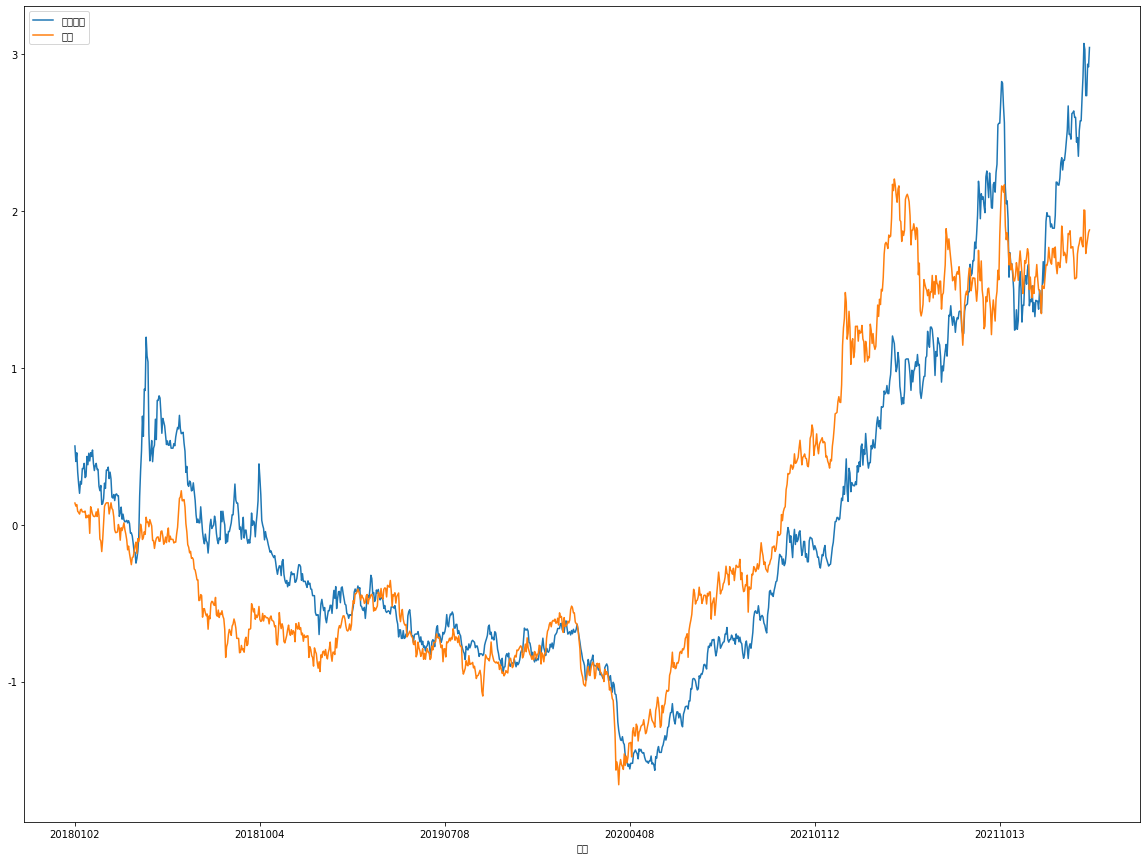

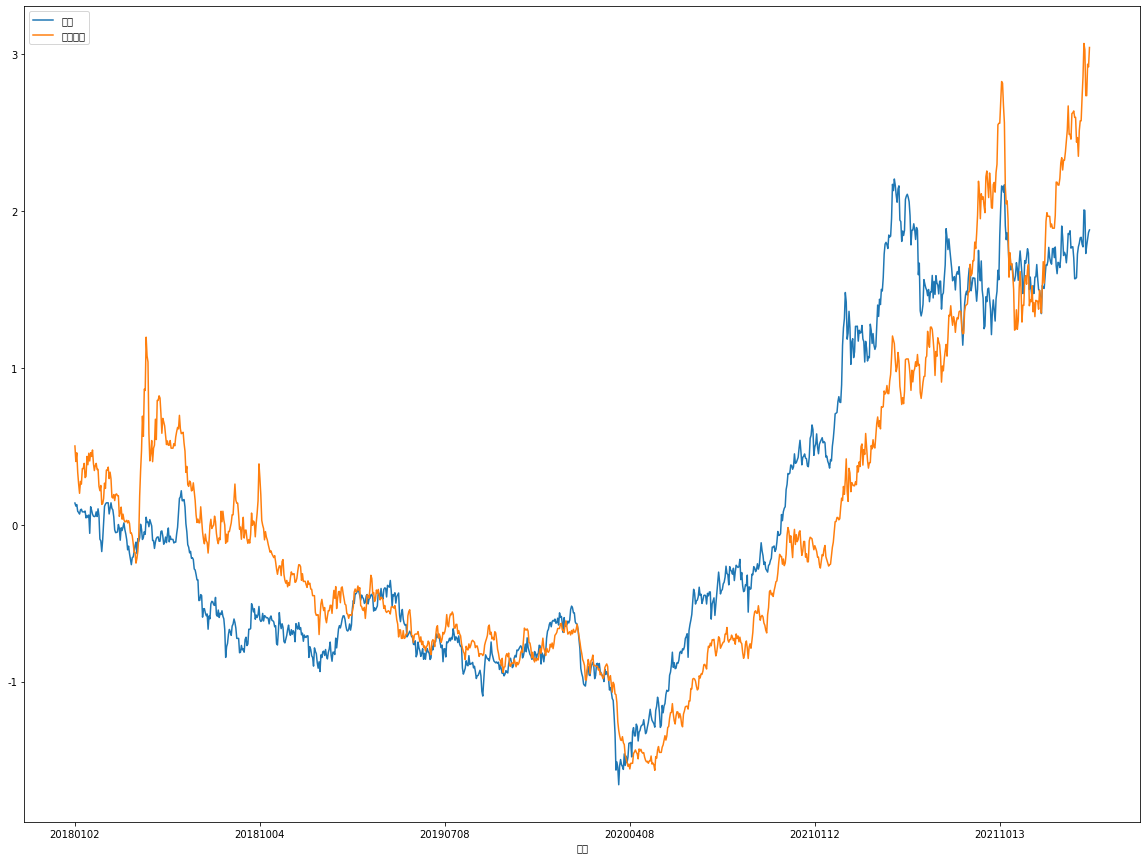

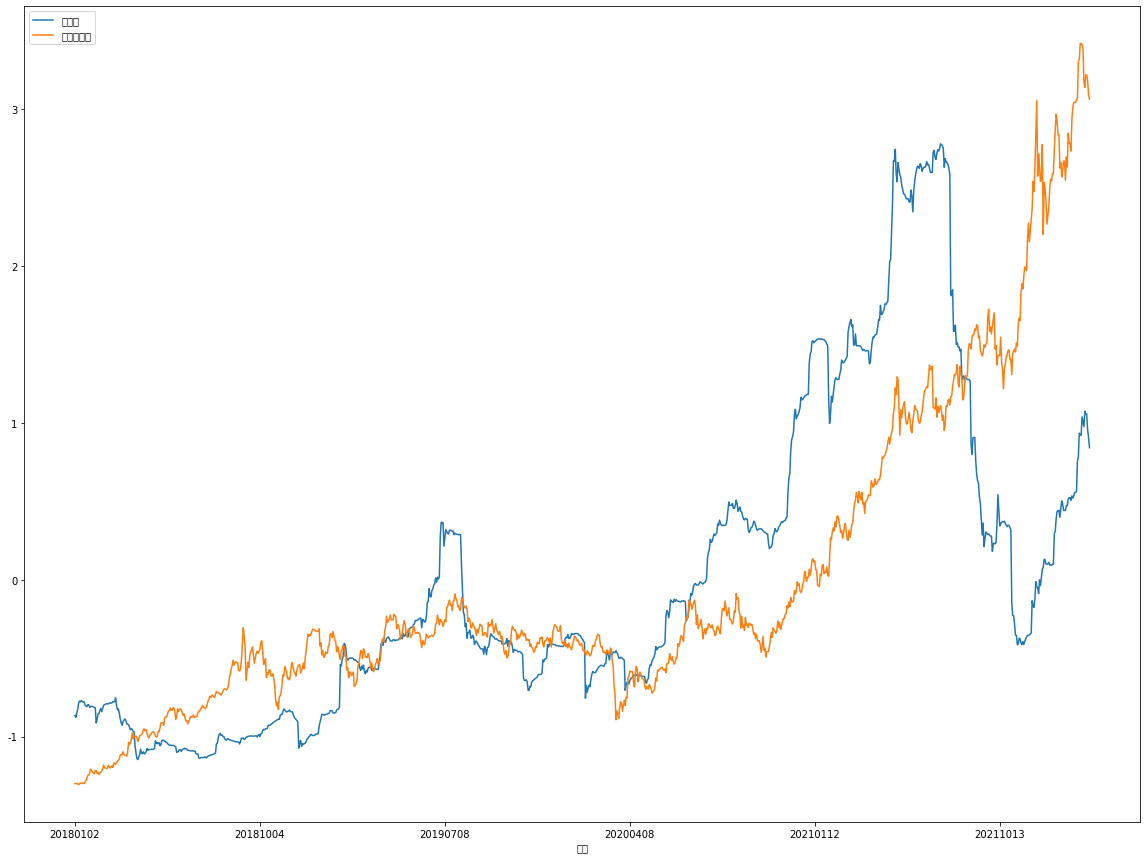

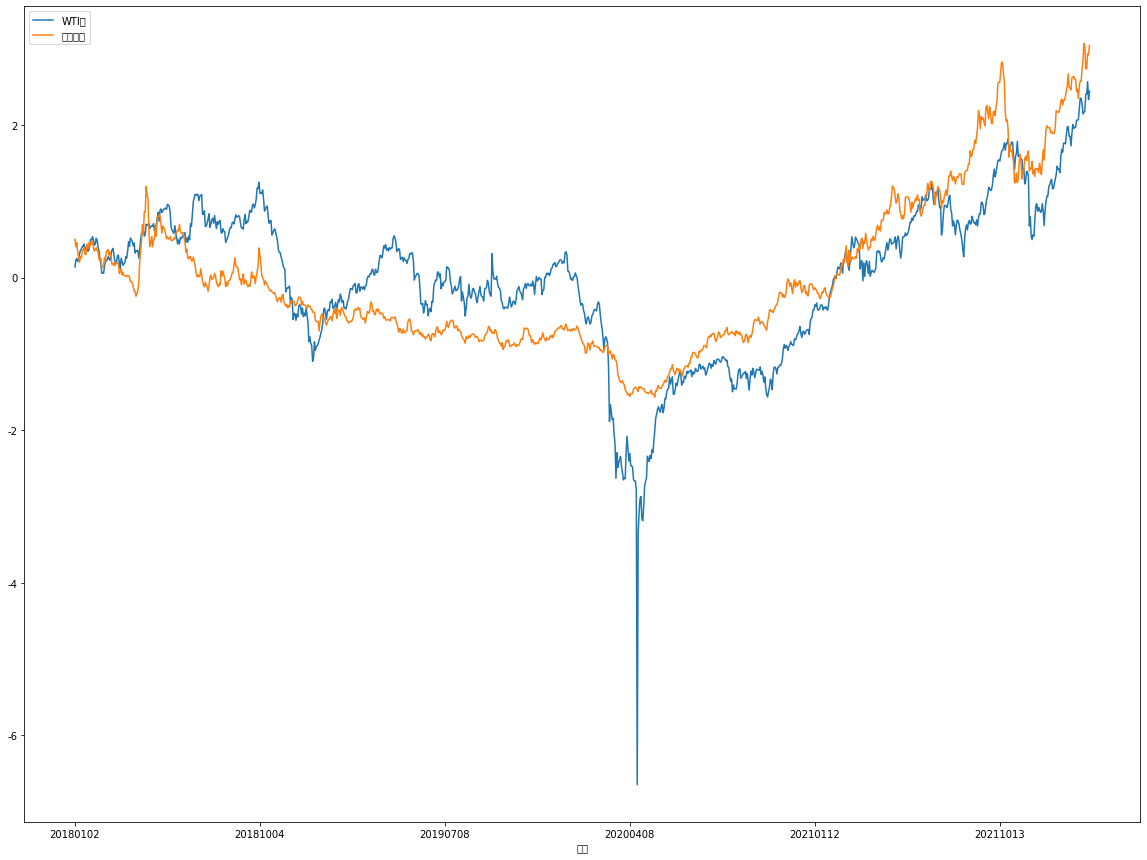

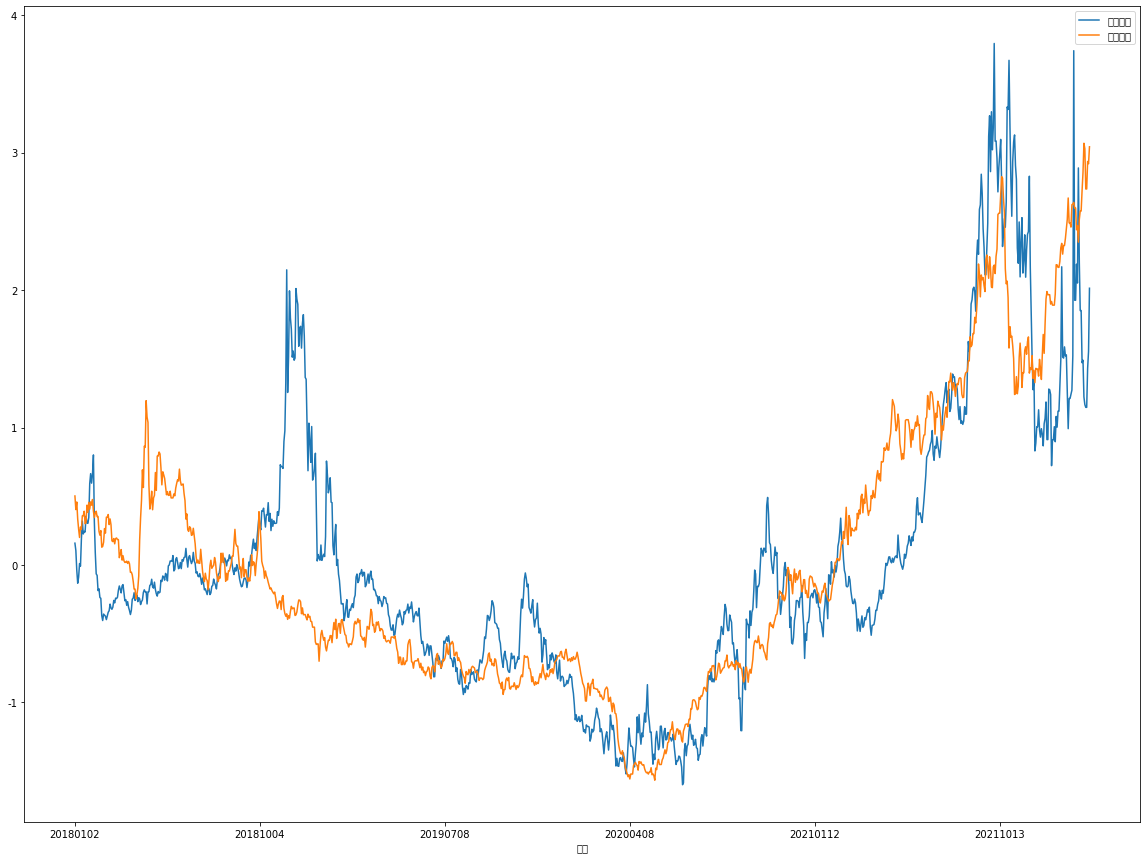

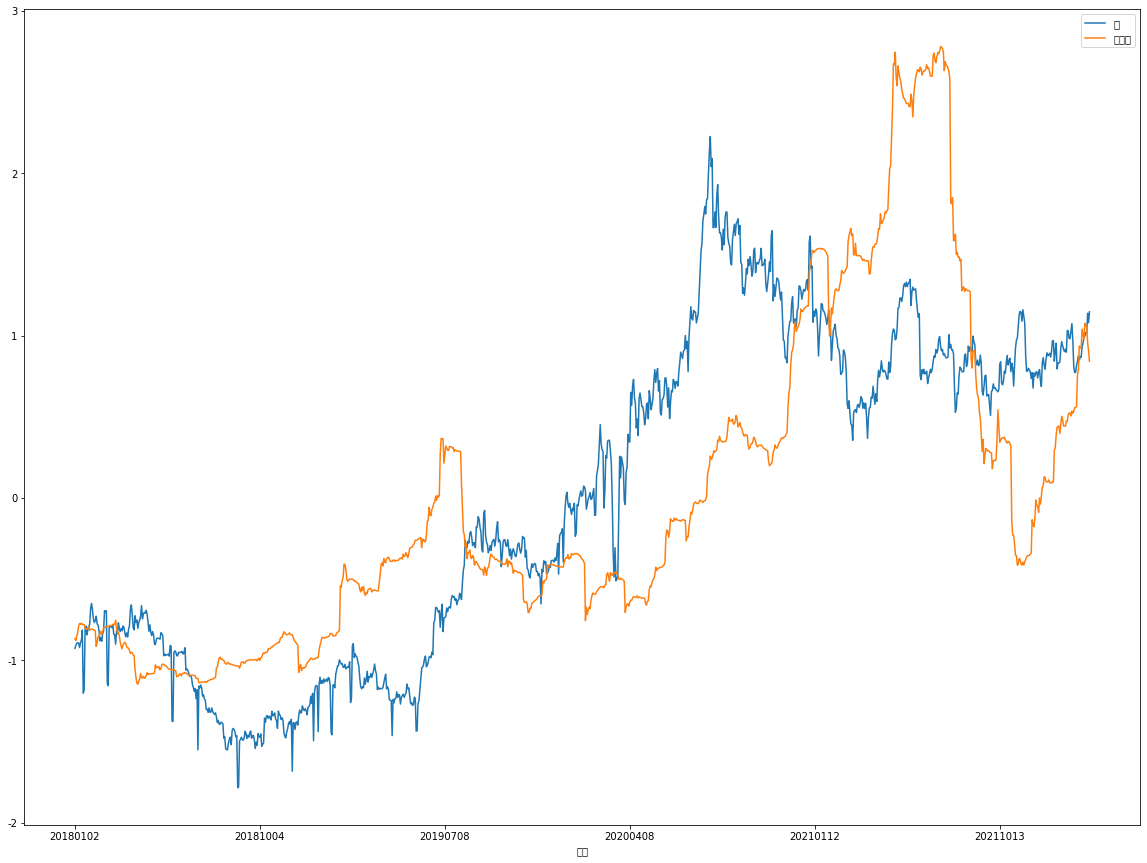

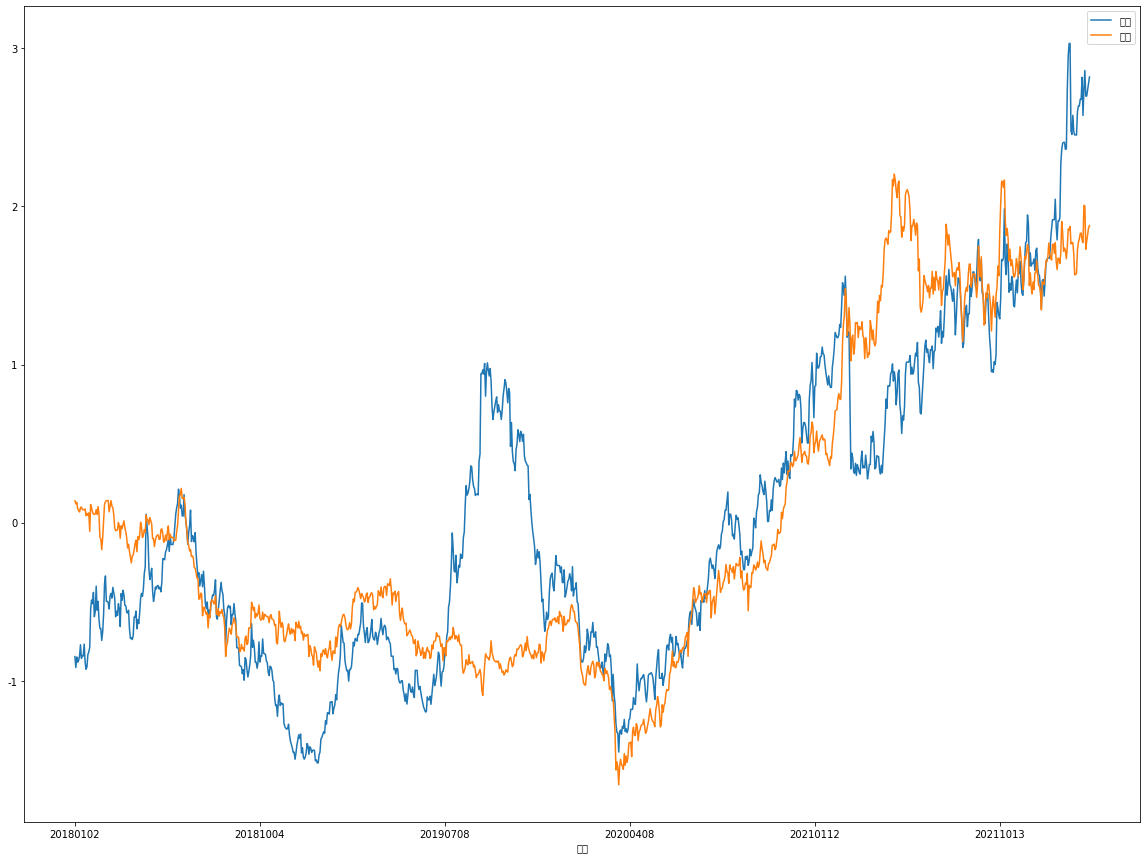

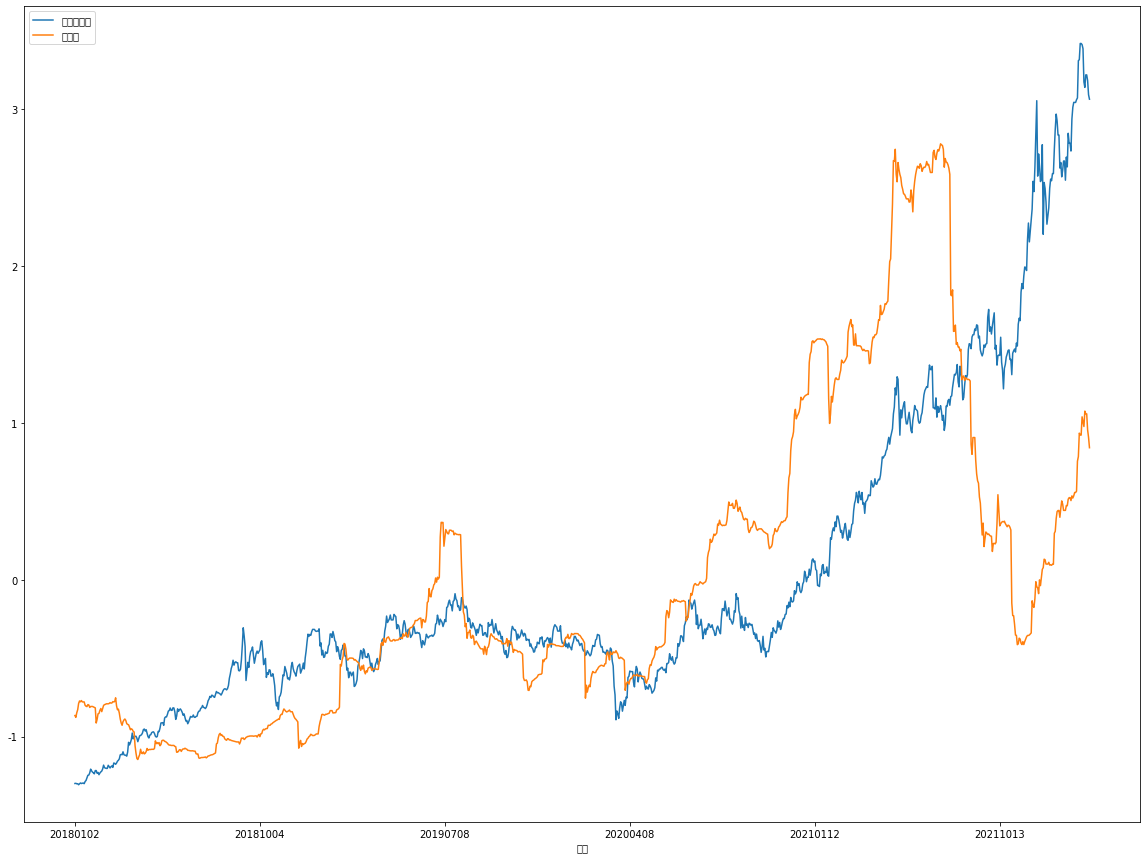

In [12]:

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
for i in range(0,len(corr.index)):
  high_correlation=corr.iloc[i].sort_values(ascending = False)[0:2].index.tolist()
  print(high_correlation)
  print(corr.iloc[i].sort_values(ascending = False)[0:5].tolist())
  df_mean_norm = mean_norm(index1[high_correlation])
  df_mean_norm.plot.line(figsize=(20,15))
